
<h2 style="color:Blue"> Instacart Market Basket Analysis </h2>


<p> <font size="3" color="black">Instacart, a Famous grocery delivery platform, has made its "Instacart Online Grocery Shopping Dataset 2017" available to the public, containing over 3 million orders from 200,000 users. Within each user profile lie 4 to 100 orders, accompanied by comprehensive details on product sequences, order timing, and intervals between orders.</font></p>

<h2 style="color:blue">Objective:</h2>

<p><font size ="3" color = "black">The objective is to anticipate the products that will feature in a user's forthcoming order.</font></p>

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
from pandas.api.types import CategoricalDtype
import re
import math

colors = ['#ff9999', '#66b3ff']

%matplotlib inline


<p>Before we start exploring the data in detail, let's gain a better understanding of the files provided. To achieve this, we'll begin by loading all the files into DataFrame objects and then examine the initial rows of each file.</p>

<p>Memory Reduction Function (reduce_memory_usage): The core of the script is the reduce_memory_usage function, which takes a DataFrame as input and iterates through its columns to reduce memory usage.</p>

In [2]:
def reduce_memory_usage(df):
    for col in df.columns:
        col_dtype = df[col].dtype
        
        if col_dtype != object:
            col_min = df[col].min()
            col_max = df[col].max()
            
            if str(col_dtype)[:3] == 'int':
                if col_min > np.iinfo(np.int8).min and col_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif col_min > np.iinfo(np.int16).min and col_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif col_min > np.iinfo(np.int32).min and col_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                else:
                    df[col] = df[col].astype(np.int64)
            
            else:
                if col_min > np.finfo(np.float32).min and col_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
    return df


<h2 style="color:blue">Reading The Data</h2>

In [3]:
orders = pd.read_csv('orders.csv')
orders = reduce_memory_usage(orders)

products = pd.read_csv('products.csv')
products = reduce_memory_usage(products)

order_products__train = pd.read_csv('order_products__train.csv')
order_products__train = reduce_memory_usage(order_products__train)

order_products__prior = pd.read_csv('order_products__prior.csv')
order_products__prior = reduce_memory_usage(order_products__prior)

departments = pd.read_csv('departments.csv')
departments = reduce_memory_usage(departments)

aisles = pd.read_csv('aisles.csv')
aisles = reduce_memory_usage(aisles)



In [4]:
print('Shape of ordertable: ',orders.shape)
orders.head(10)

Shape of ordertable:  (3421083, 7)


order_id  user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   2539329        1    prior             1          2                  8   
1   2398795        1    prior             2          3                  7   
2    473747        1    prior             3          3                 12   
3   2254736        1    prior             4          4                  7   
4    431534        1    prior             5          4                 15   
5   3367565        1    prior             6          2                  7   
6    550135        1    prior             7          1                  9   
7   3108588        1    prior             8          1                 14   
8   2295261        1    prior             9          1                 16   
9   2550362        1    prior            10          4                  8   

   days_since_prior_order  
0                     NaN  
1                    15.0  
2                    21.0  
3                    29.0  
4                    28.0  
5                    19.0  
6                    20.0  
7                    14.0  
8                     0.0  
9                    30.0

In [5]:
print('Shape of products table: ',products.shape)
products.head(10)

Shape of products table:  (49688, 4)


product_id                                       product_name  aisle_id  \
0           1                         Chocolate Sandwich Cookies        61   
1           2                                   All-Seasons Salt       104   
2           3               Robust Golden Unsweetened Oolong Tea        94   
3           4  Smart Ones Classic Favorites Mini Rigatoni Wit...        38   
4           5                          Green Chile Anytime Sauce         5   
5           6                                       Dry Nose Oil        11   
6           7                     Pure Coconut Water With Orange        98   
7           8                  Cut Russet Potatoes Steam N' Mash       116   
8           9                  Light Strawberry Blueberry Yogurt       120   
9          10     Sparkling Orange Juice & Prickly Pear Beverage       115   

   department_id  
0             19  
1             13  
2              7  
3              1  
4             13  
5             11  
6              7  
7              1  
8             16  
9              7

In [6]:
print('Shape of order products train table: ',order_products__train.shape)
order_products__train.head(10)

Shape of order products train table:  (1384617, 4)


order_id  product_id  add_to_cart_order  reordered
0         1       49302                  1          1
1         1       11109                  2          1
2         1       10246                  3          0
3         1       49683                  4          0
4         1       43633                  5          1
5         1       13176                  6          0
6         1       47209                  7          0
7         1       22035                  8          1
8        36       39612                  1          0
9        36       19660                  2          1

In [7]:
print('Shape of order products prior table: ',order_products__prior.shape)
order_products__prior.head(10)

Shape of order products prior table:  (32434489, 4)


order_id  product_id  add_to_cart_order  reordered
0         2       33120                  1          1
1         2       28985                  2          1
2         2        9327                  3          0
3         2       45918                  4          1
4         2       30035                  5          0
5         2       17794                  6          1
6         2       40141                  7          1
7         2        1819                  8          1
8         2       43668                  9          0
9         3       33754                  1          1

In [8]:
print('Shape of departments table: ',departments.shape)
departments.head(10)

Shape of departments table:  (21, 2)


department_id       department
0              1           frozen
1              2            other
2              3           bakery
3              4          produce
4              5          alcohol
5              6    international
6              7        beverages
7              8             pets
8              9  dry goods pasta
9             10             bulk

In [9]:
print('Shape of aisles table: ',aisles.shape)
aisles.head(10)

Shape of aisles table:  (134, 2)


aisle_id                       aisle
0         1       prepared soups salads
1         2           specialty cheeses
2         3         energy granola bars
3         4               instant foods
4         5  marinades meat preparation
5         6                       other
6         7               packaged meat
7         8             bakery desserts
8         9                 pasta sauce
9        10            kitchen supplies

<p>Here's a breakdown of each table and its columns:</p>


<h3>Order Table: </h3>


<p>order_id: Unique identifier for each order.</p>
<p>user_id: Unique identifier for each user.</p>
<p>eval_set: Indicates which evaluation set this order belongs to (train, test, or prior).</p>
<p>order_number: The sequence number for this order (1 for the first order, 2 for the second, etc.).</p>
<p>order_dow: The day of the week the order was placed (0 for Sunday, 1 for Monday, etc.).</p>
<p>order_hour_of_day: The hour of the day the order was placed.</p>
<p>days_since_prior_order: Number of days since the previous order.</p>


<h3>Products Table:</h3>

<p>product_id: Unique identifier for each product.</p>
<p>product_name: Name of the product.</p>
<p>aisle_id: Identifier for the aisle where the product is located.</p>
<p>department_id: Identifier for the department where the product belongs.</p>


<h3>Order Products Train Table:</h3>

<p>order_id: Identifier for the order.</p>
<p>product_id: Identifier for the product.</p>
<p>add_to_cart_order: The order in which the product was added to the cart.</p>
<p>reordered: Indicates if the product was reordered in this order (1 for reordered, 0 otherwise).</p>


<h3>Order Products Prior Table:</h3>

<p>order_id: Identifier for the order.</p>
<p>product_id: Identifier for the product.</p>
<p>add_to_cart_order: The order in which the product was added to the cart.</p>
<p>reordered: Indicates if the product was reordered in this order (1 for reordered, 0 otherwise).</p>


<h3>Departments Table:</h3>

<p>department_id: Identifier for the department.</p>
<p>department: Name of the department.</p>

<h3>Aisles Table:</h3>

<p>aisle_id: Identifier for the aisle.</p>
<p>aisle: Name of the aisle.</p>

 

<h2>Data Cleaning and Preprocessing:</h2>

In [10]:
# Function to label bars
def autolabel(rects, labels, height_factor=1.2, fontsize=13):
    """Attach a text label above each bar in *rects*, displaying its height."""
    for rect, label in zip(rects, labels):
        height = rect.get_height()
        ax.annotate('{}'.format(label),
                    xy=(rect.get_x() + rect.get_width() / 2, height+.5),
                    xytext=(0, height_factor),
                    textcoords="offset points",
                    ha='center', va='bottom',
                    fontsize=fontsize)  


In [11]:
def convert_to_12_hour(hour):
    if hour == 0:
        return "12 AM"
    elif hour < 12:
        return f"{hour} AM"
    elif hour == 12:
        return "12 PM"
    else:
        return f"{hour - 12} PM"

# Apply the conversion function to the 'order_hour_of_day' column
orders['order_hour_of_day_12'] = orders['order_hour_of_day'].apply(convert_to_12_hour)

# Display the DataFrame with the new 12-hour format column
print(orders[['order_hour_of_day', 'order_hour_of_day_12']])

         order_hour_of_day order_hour_of_day_12
0                        8                 8 AM
1                        7                 7 AM
2                       12                12 PM
3                        7                 7 AM
4                       15                 3 PM
...                    ...                  ...
3421078                 18                 6 PM
3421079                 10                10 AM
3421080                 12                12 PM
3421081                 12                12 PM
3421082                 14                 2 PM

[3421083 rows x 2 columns]


In [12]:
# Dictionary mapping numbers to day names
day_of_week_mapping = {
    0: 'Sunday',
    1: 'Monday',
    2: 'Tuesday',
    3: 'Wednesday',
    4: 'Thursday',
    5: 'Friday',
    6: 'Saturday'
}

orders['order_dow_name'] = orders['order_dow'].apply(lambda x: day_of_week_mapping[x])

<h2>First get the count Orders over the entire dataset</h2>

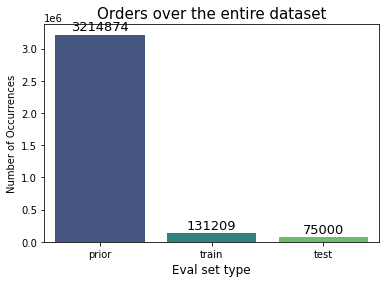

In [13]:
cnt_es = orders.eval_set.value_counts()


# Create barplot using Seaborn
ax = sns.barplot(x=cnt_es.index, y=cnt_es.values, palette='viridis')

# Adding data labels
autolabel(ax.patches, cnt_es.values)


# Adding titles and labels
plt.title('Orders over the entire dataset', fontsize=15)
plt.xlabel('Eval set type', fontsize=12)
plt.ylabel('Number of Occurrences')

plt.show()

There are 3,214,874 orders in total. Out of which, the last purchase of 131,209 orders are given as train set and we need to predict for the rest 75,000 orders.

<h2>Clients over the entire dataset</h2>

In [14]:
# Define a function to get the count of unique customer in a orders table
def get_unique_count(array):
   return len(np.unique(array))

# Group the "user_id" column of the orders_df DataFrame by the "eval_set" column
# and then aggregate using the get_unique_count function to get the count of unique user IDs for each eval_set
unique_user_counts = orders.groupby("eval_set")["user_id"].aggregate(get_unique_count)

unique_user_counts


eval_set
prior    206209
test      75000
train    131209
Name: user_id, dtype: int64

Out of a total of 206,209 customers, 131,209 customers have their last purchase included in the training set. The task involves predicting for the remaining 75,000 customers whose last purchases are not included in the training set.

<p>Distribution of Orders by Hour of Day </P>

Analyzing the distribution of orders by hour of the day provides valuable insights that can help businesses optimize their operations, improve customer experience, and drive growth and profitability.


<h2>Time of orders</h2>

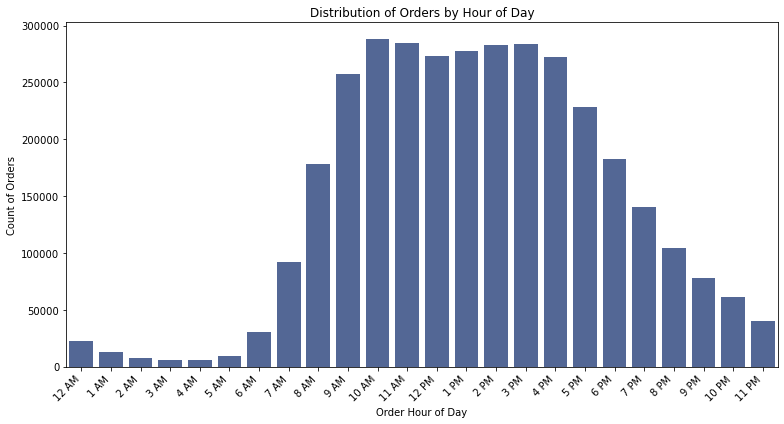

In [15]:
plt.figure(figsize=(11,6))
hour_counts = orders['order_hour_of_day_12'].value_counts()

# Sort the index (hours) in the correct order
hour_order = ['12 AM', '1 AM', '2 AM', '3 AM', '4 AM', '5 AM', '6 AM', '7 AM', '8 AM', '9 AM', '10 AM', '11 AM',
              '12 PM', '1 PM', '2 PM', '3 PM', '4 PM', '5 PM', '6 PM', '7 PM', '8 PM', '9 PM', '10 PM', '11 PM']

hour_counts = hour_counts.reindex(hour_order)

# Plot the sorted data
sns.barplot(x=hour_counts.index, y=hour_counts.values, color ='#4863A0')

# Add labels and title
plt.xlabel('Order Hour of Day')
plt.ylabel('Count of Orders')
plt.title('Distribution of Orders by Hour of Day')

# Rotate the x-axis labels for better readability
plt.xticks(rotation=45, ha='right')

# Show the plot
plt.tight_layout()
plt.show()


Typically, orders are predominantly placed during daytime hours, typically between 8:00 AM and 5:00 PM.

<h2>Number of orders made for each day of the week. ( Days of Orders in a week)</h2>

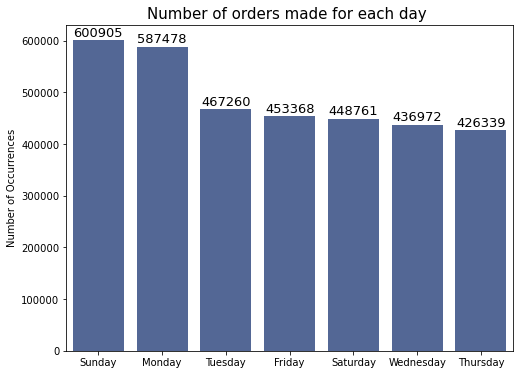

In [16]:
order_count_per_day = orders['order_dow_name'].value_counts()
plt.figure(figsize=(8,6))

# Create barplot using Seaborn
ax = sns.barplot(x=order_count_per_day.index , y=order_count_per_day.values, color ='#4863A0')

# Adding data labels
autolabel(ax.patches, order_count_per_day.values)
# Adding titles and labels
plt.title('Number of orders made for each day ', fontsize=15)
plt.ylabel('Number of Occurrences')

plt.show()

In [17]:
order_count_per_day = orders['order_dow_name'].value_counts()

# Print the result
print("Number of orders made for each day of the week:")
print(order_count_per_day)

Number of orders made for each day of the week:
Sunday       600905
Monday       587478
Tuesday      467260
Friday       453368
Saturday     448761
Wednesday    436972
Thursday     426339
Name: order_dow_name, dtype: int64


<h2>Number of Orders by Day of Week and Hour of Day</h2>

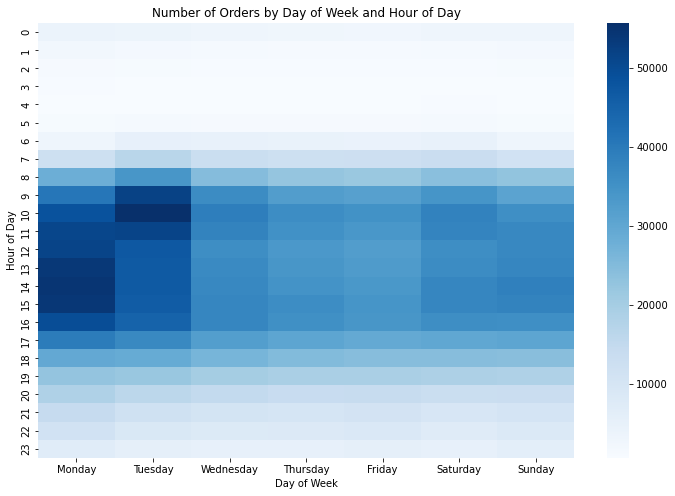

In [18]:
# Group by 'order_dow' and 'order_hour_of_day' and count the number of orders
heatmap_data = orders.groupby(['order_dow', 'order_hour_of_day']).size().reset_index(name='count')

# Reshape the data to create a pivot table
heatmap_data = heatmap_data.pivot('order_hour_of_day', 'order_dow', 'count')

# Set the order of days to be displayed on the heatmap
day_order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(heatmap_data, cmap="Blues" , xticklabels=day_order)
plt.title('Number of Orders by Day of Week and Hour of Day')
plt.xlabel('Day of Week')
plt.ylabel('Hour of Day')
plt.show()

 Saturday evenings and Sunday mornings appear to be prime times for orders based on the combination of day of the week and hour of the day

## Merging the Prior and Train order_products

In [19]:
# Merging the Prior and Train order_products
order_products = pd.concat([order_products__train, order_products__prior])
order_products = order_products.merge(products, on='product_id', how='left') \
                                             .merge(orders, on='order_id', how='left') \
                                             .merge(departments, on='department_id') \
                                             .merge(aisles, on='aisle_id')

# Counting total orders
total_orders =order_products['order_id'].nunique()
print('Count of total orders:', total_orders)

print('Merging products, order_products, and orders tables...')

# Displaying the head of the merged DataFrame
order_products.head()

Count of total orders: 3346083
Merging products, order_products, and orders tables...


order_id  product_id  add_to_cart_order  reordered  \
0         1       49302                  1          1   
1        98       43654                  3          1   
2       170        8153                  6          0   
3       631        9203                 13          1   
4       631       15842                 14          1   

                                        product_name  aisle_id  department_id  \
0                                   Bulgarian Yogurt       120             16   
1       Whole Milk Greek Blended Vanilla Bean Yogurt       120             16   
2                         Plain Non-Fat Greek Yogurt       120             16   
3  Dairy Free Coconut Milk Raspberry Yogurt Alter...       120             16   
4         Dairy Free Coconut Milk Yogurt Alternative       120             16   

   user_id eval_set  order_number  order_dow  order_hour_of_day  \
0   112108    train             4          4                 10   
1    56463    train            41          3                  8   
2   182389    train             7          0                 13   
3   184099    train             7          3                  9   
4   184099    train             7          3                  9   

   days_since_prior_order order_hour_of_day_12 order_dow_name  department  \
0                     9.0                10 AM       Thursday  dairy eggs   
1                    14.0                 8 AM      Wednesday  dairy eggs   
2                    14.0                 1 PM         Sunday  dairy eggs   
3                    30.0                 9 AM      Wednesday  dairy eggs   
4                    30.0                 9 AM      Wednesday  dairy eggs   

    aisle  
0  yogurt  
1  yogurt  
2  yogurt  
3  yogurt  
4  yogurt

## Most ordered Products (Analyzing  products  )

Bestsellers
Let’s have a look which products are sold most often (top10). And the clear winner is: Bananas


    product_id   count            product_name
0        24852  491291                  Banana
1        13176  394930  Bag of Organic Bananas
2        21137  275577    Organic Strawberries
3        21903  251705    Organic Baby Spinach
4        47209  220877    Organic Hass Avocado
5        47766  184224         Organic Avocado
6        47626  160792             Large Lemon
7        16797  149445            Strawberries
8        26209  146660                   Limes
9        27845  142813      Organic Whole Milk
10       27966  142603     Organic Raspberries
11       22935  117716    Organic Yellow Onion
12       24964  113936          Organic Garlic
13       45007  109412        Organic Zucchini
14       39275  105026     Organic Blueberries


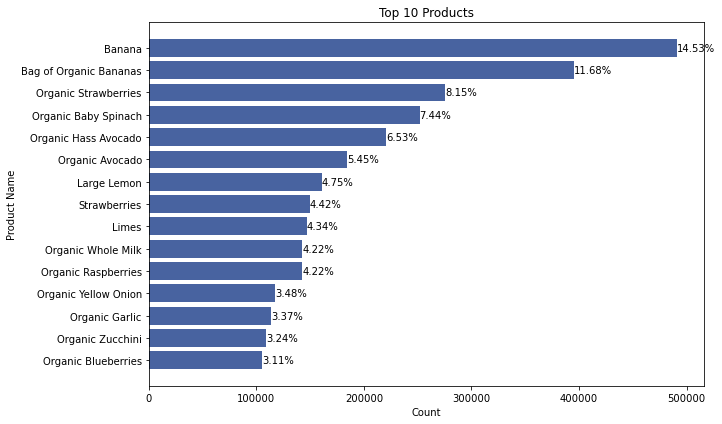

In [20]:
tmp = order_products.groupby('product_id').size().reset_index(name='count')

# Selecting the top 10 products based on count
top_products = tmp.nlargest(15, 'count')

# Merging with 'products' dataframe to get product names
top_products = top_products.merge(products[['product_id', 'product_name']], on='product_id', how='left')

# Sorting the dataframe by count in descending order
top_products = top_products.sort_values(by='count', ascending=False)

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(top_products['product_name'], top_products['count'], color='#4863A0')
plt.xlabel('Count')
plt.ylabel('Product Name')
plt.title('Top 10 Products')
plt.gca().invert_yaxis()  # Invert y-axis to display the product with the highest count at the top
plt.tight_layout()

# Adding data labels to the bars
for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height()/2, f'{width / len(order_products) * 1000:.2f}%', 
             va='center', ha='left', fontsize=10, color='black')


# Display the dataframe
print(top_products)

plt.show()

In [21]:
del tmp

In prior orders, 58.9697% of products were re-ordered.
In train orders, 59.8594% of products were re-ordered.
Percentage of orders without any reordered product: 11.868056%
Percentage of orders with all products re-ordered: 21.493998%


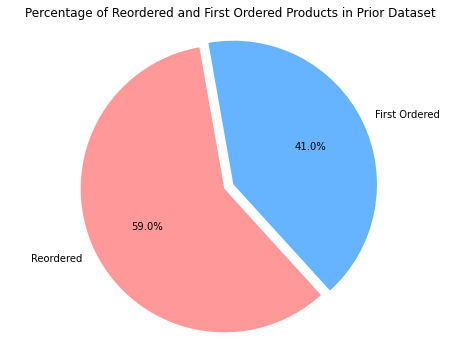

In [22]:
# Calculate the percentage of products in prior orders that were re-ordered
prior_reordered_percentage = (order_products__prior['reordered'].sum() / len(order_products__prior)) * 100
prior_first_ordered_percentage = ((len(order_products__prior) - order_products__prior['reordered'].sum()) / len(order_products__prior)) * 100

# Calculate the percentage of products in train orders that were re-ordered
train_reordered_percentage = (order_products__train['reordered'].sum() / len(order_products__train)) * 100

# Calculate the percentage of orders having no reordered product
no_reordered_orders_percentage = ((order_products.groupby('order_id')['reordered'].sum() == 0).mean()) * 100

# Calculate the percentage of orders having all products re-ordered
all_reordered_orders_percentage = ((order_products.groupby('order_id')['reordered'].sum() == 
                                    order_products.groupby('order_id')['reordered'].count()).mean()) * 100

print(f"In prior orders, {prior_reordered_percentage:.4f}% of products were re-ordered.")
print(f"In train orders, {train_reordered_percentage:.4f}% of products were re-ordered.")
print(f"Percentage of orders without any reordered product: {no_reordered_orders_percentage:.6f}%")
print(f"Percentage of orders with all products re-ordered: {all_reordered_orders_percentage:.6f}%")


labels = ['Reordered', 'First Ordered']
percentages = [prior_reordered_percentage, prior_first_ordered_percentage]
explode = (0.07, 0)
# Create a pie plot
plt.figure(figsize=(8, 6))
plt.pie(percentages,explode =explode, labels=labels, autopct='%1.1f%%', colors=colors, startangle=100)
plt.title('Percentage of Reordered and First Ordered Products in Prior Dataset')
plt.axis('equal')  
plt.show()

<h2>Most Reordered Products</h2>

In [23]:
# Group order_products_all by product_id and calculate reorder statistics
Most_Reordered = order_products.groupby("product_id").agg(reorder_sum=('reordered', 'sum'),
                                                      reorder_total=('reordered', 'count')).reset_index()

# Calculate reorder probability
Most_Reordered['reorder_probability'] = Most_Reordered['reorder_sum'] / Most_Reordered['reorder_total']

# Merge with products to get product names
Most_Reordered = pd.merge(Most_Reordered, products[['product_id', 'product_name']], how='left', on='product_id')

# Filter and select top 10 products with highest reorder probability
Most_Reordered = Most_Reordered[Most_Reordered['reorder_total'] > 75].sort_values(by='reorder_probability', ascending=False).head(10)

# Display the result
Most_Reordered


product_id  reorder_sum  reorder_total  reorder_probability  \
2074         2075         84.0             90             0.933333   
27737       27740         94.0            102             0.921569   
35601       35604         93.0            104             0.894231   
38248       38251         99.0            111             0.891892   
36798       36801         88.0             99             0.888889   
10233       10236        114.0            131             0.870229   
20595       20598         99.0            114             0.868421   
5455         5457         78.0             90             0.866667   
35493       35496        394.0            457             0.862144   
9289         9292       2580.0           2995             0.861436   

                                            product_name  
2074            Serenity Ultimate Extrema Overnight Pads  
27737                                 Chocolate Love Bar  
35601                                    Maca Buttercups  
38248                              Benchbreak Chardonnay  
36798                           Organic Blueberry B Mega  
10233  Fragrance Free Clay with Natural Odor Eliminat...  
20595                         Thousand Island Salad Snax  
5455            Classic Carbonated Natural Mineral Water  
35493                       Real2 Alkalized Water 500 ml  
9289                     Half And Half Ultra Pasteurized

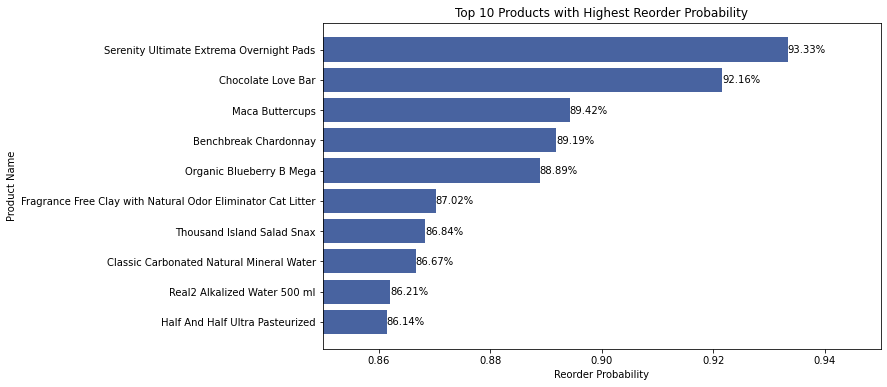

In [24]:
plt.figure(figsize=(10, 6))
bars = plt.barh(Most_Reordered['product_name'], Most_Reordered['reorder_probability'], color='#4863A0')

# Add labels and title
plt.xlabel('Reorder Probability')
plt.ylabel('Product Name')
plt.title('Top 10 Products with Highest Reorder Probability')

# Invert y-axis to display the highest probability at the top
plt.gca().invert_yaxis()

# Add data labels to the bars
for bar, label in zip(bars, Most_Reordered['reorder_probability']):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{label:.2%}', 
             va='center', ha='left', fontsize=10)

plt.xlim([0.85, 0.95])
plt.show()

### Top 10 Products Added First to Basket:            Analyzing products

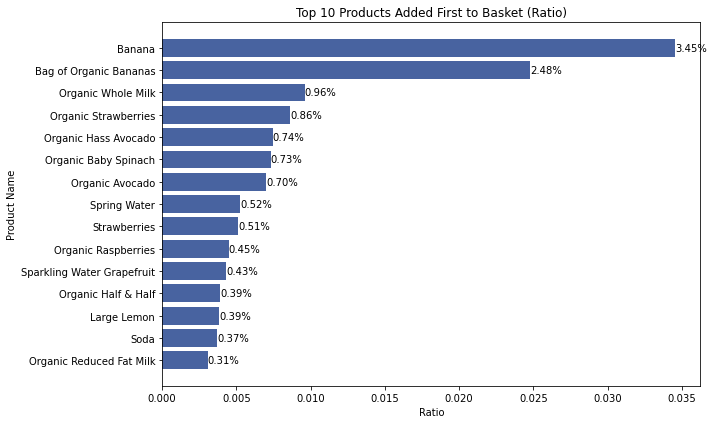

In [25]:
# Grouping by 'product_id' and calculating the count of each product added first to the basket
first_in_basket = order_products[order_products['add_to_cart_order'] == 1]
first_in_basket_counts = first_in_basket['product_id'].value_counts().reset_index()
first_in_basket_counts.columns = ['product_id', 'count']

# Merging with 'products' dataframe to get product names
first_in_basket_counts = first_in_basket_counts.merge(products[['product_id', 'product_name']], on='product_id', how='left')

# Sorting the dataframe by count in descending order
first_in_basket_counts = first_in_basket_counts.sort_values(by='count', ascending=False)

# Calculate the total count of products added first to the basket
total_count = first_in_basket_counts['count'].sum()

# Calculate the ratio for each product
first_in_basket_counts['ratio'] = first_in_basket_counts['count'] / total_count

# Create a bar plot
plt.figure(figsize=(10, 6))
bars = plt.barh(first_in_basket_counts['product_name'][:15], first_in_basket_counts['ratio'][:15], color='#4863A0')
plt.xlabel('Ratio')
plt.ylabel('Product Name')
plt.title('Top 10 Products Added First to Basket (Ratio)')
plt.gca().invert_yaxis() 

# Adding data labels (annotations) to the bars
for bar, label in zip(bars, first_in_basket_counts['ratio'][:15]):
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, f'{label:.2%}', 
             va='center', ha='left', fontsize=10)

plt.tight_layout()
plt.show()


The data reveals that certain products, such as Bananas, Bag of Organic Bananas, and Organic Whole Milk, are consistently among the top items added first to the basket. This suggests that these products hold significant importance to customers and are likely considered essential or preferred choices.

Most of them are organic products.! Also majority of them are fruits.

###  Analyzing the top products with the highest ratio of reordered purchases.

                                   product_name  reordered_ratio  \
6431                        Raw Veggie Wrappers         0.942029   
2074   Serenity Ultimate Extrema Overnight Pads         0.933333   
43550                       Orange Energy Shots         0.923077   
27737                        Chocolate Love Bar         0.921569   
14606                 Soy Powder Infant Formula         0.914286   
13872          Simply Sleep Nighttime Sleep Aid         0.911111   
39989                 Energy Shot, Grape Flavor         0.909091   
5866    Russian River Valley Reserve Pinot Noir         0.900000   
36540                        Bars Peanut Butter         0.898551   
26090                 Soy Crisps Lightly Salted         0.895522   

       total_purchases  total_reordered  
6431                69             65.0  
2074                90             84.0  
43550               13             12.0  
27737              102             94.0  
14606               35             32.0  

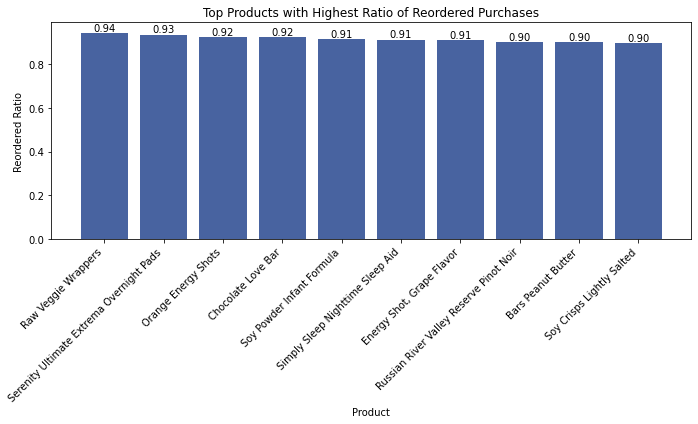

In [26]:
# Group by 'product_id' and calculate the total number of purchases and the total number of reordered purchases for each product
product_purchase_counts = order_products.groupby('product_id')['order_id'].count().reset_index(name='total_purchases')
product_reordered_counts = order_products.groupby('product_id')['reordered'].sum().reset_index(name='total_reordered')

# Merge with 'products' DataFrame to get product names
product_purchase_counts = product_purchase_counts.merge(products[['product_id', 'product_name']], on='product_id', how='left')

# Merge the purchase and reorder counts
product_purchase_counts = product_purchase_counts.merge(product_reordered_counts, on='product_id', how='left')

# Calculate the ratio of reordered purchases to total purchases
product_purchase_counts['reordered_ratio'] = product_purchase_counts['total_reordered'] / product_purchase_counts['total_purchases']

# Sort the DataFrame by reordered_ratio in descending order and select the top products
top_products = product_purchase_counts.sort_values(by='reordered_ratio', ascending=False).head(10)

# Print the top products with the highest ratio of reordered purchases and the corresponding total number of purchases and total number of reordered purchases
print(top_products[['product_name', 'reordered_ratio', 'total_purchases', 'total_reordered']])

# Create a vertical bar plot to show the top products with the highest ratio of reordered purchases
plt.figure(figsize=(10, 6))
bars = plt.bar(top_products['product_name'], top_products['reordered_ratio'], color='#4863A0')

# Add data labels to the bars
for bar in bars:
    plt.text(bar.get_x() + bar.get_width() / 2, bar.get_height(), 
             f'{bar.get_height():.2f}', 
             ha='center', va='bottom', fontsize=10, color='black')

plt.xlabel('Product')
plt.ylabel('Reordered Ratio')
plt.title('Top Products with Highest Ratio of Reordered Purchases')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()


Products like "Raw Veggie Wrappers," "Serenity Ultimate Extrema Overnight Pads," and "Orange Energy Shots"     exhibit very high reordered ratios (ranging from 90% to 94%). This suggests a high level of customer loyalty, as a    significant proportion of customers who purchase these items tend to repurchase them.

In [27]:
del product_purchase_counts, product_reordered_counts

## Defining and analyzing the comparison between purchases and reordered purchases.

The data provides valuable insights into product popularity, consumer behavior regarding reordering, and trends that can   inform strategic decision-making for businesses in terms of marketing, inventory management, and product development.

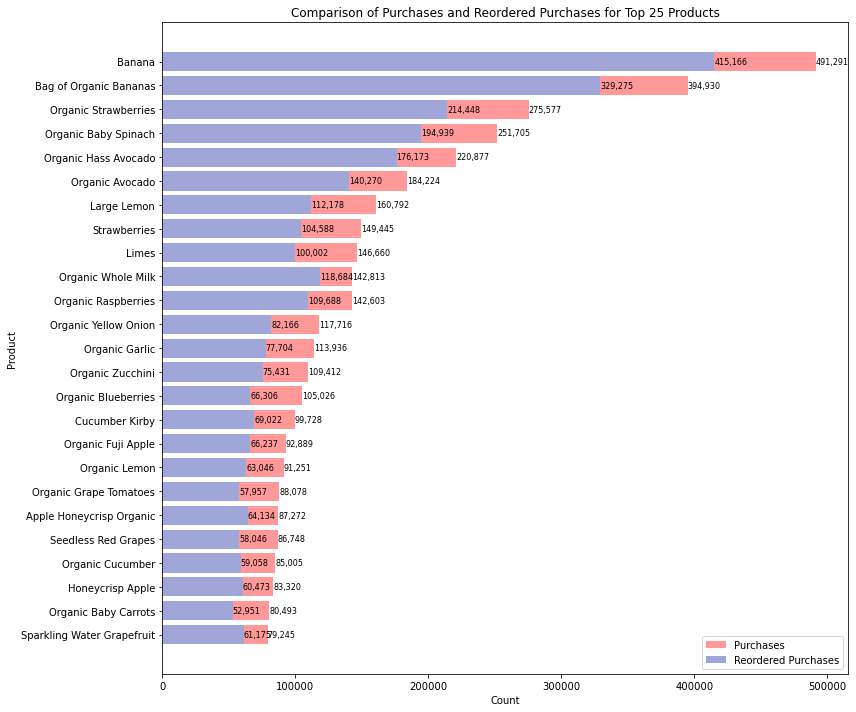

In [28]:
# Group by 'product_id' and count the number of purchases and reordered purchases for each product
product_purchase_counts = order_products.groupby('product_id')['order_id'].count().reset_index(name='purchase_count')
product_reordered_counts = order_products.groupby('product_id')['reordered'].sum().reset_index(name='reordered_count')

# Merge with 'products' DataFrame to get product names
product_purchase_counts = product_purchase_counts.merge(products[['product_id', 'product_name']], on='product_id', how='left')
product_reordered_counts = product_reordered_counts.merge(products[['product_id', 'product_name']], on='product_id', how='left')

# Calculate the total count of purchases and reordered purchases
product_purchase_counts['reordered_count'] = product_reordered_counts['reordered_count']

# Sort the DataFrame by purchase_count in descending order and select the top 25 products
top_25_products = product_purchase_counts.sort_values(by='purchase_count', ascending=False).head(25)

# Create a bar plot to compare the counts of purchases and reordered purchases for the top 25 products
plt.figure(figsize=(12, 10))
bars1 = plt.barh(top_25_products['product_name'], top_25_products['purchase_count'], color=colors[0], label='Purchases')
bars2 = plt.barh(top_25_products['product_name'], top_25_products['reordered_count'],color= '#A0A7D8' , label='Reordered Purchases')

# Add data labels to the bars
for bar in bars1:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width()):,}', 
             va='center', ha='left', fontsize=8, color='black')

for bar in bars2:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width()):,}', 
             va='center', ha='left', fontsize=8, color='black')

plt.xlabel('Count')
plt.ylabel('Product')
plt.title('Comparison of Purchases and Reordered Purchases for Top 25 Products')
plt.legend()
plt.gca().invert_yaxis() 
plt.tight_layout()
plt.show()

•	Top Purchased Items: "Banana," "Bag of Organic Bananas," and "Organic Strawberries" are among the      most frequently purchased items, indicating their popularity among customers.

•	Organic Preference: The presence of organic items indicates a preference for organic products among customers.

Healthy Choices: Products such as "Organic Whole Milk," "Organic Baby Carrots," and "Organic Cucumber" reflect a trend towards healthier food choices.


In [29]:
del product_purchase_counts, product_reordered_counts

<h2>Number of Items Bought </h2>

<Figure size 864x432 with 0 Axes>

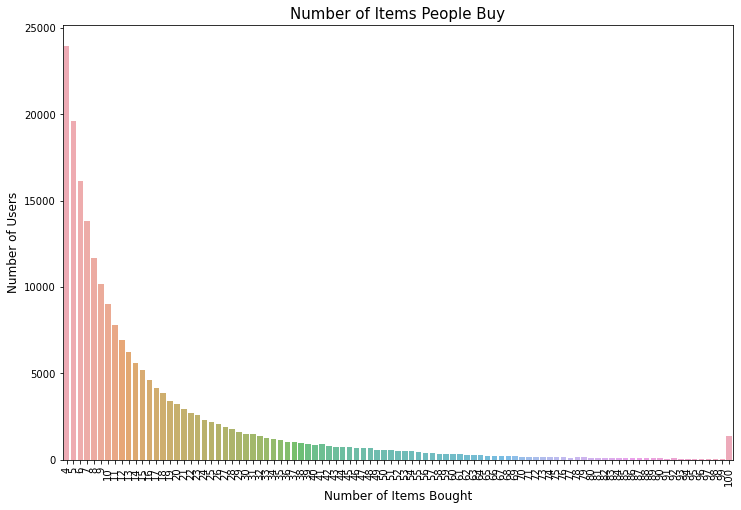

In [30]:
    plt.figure(figsize=(12,6))
    items_per_user = orders.groupby("user_id")["order_id"].count().reset_index()
    items_per_user_counts = items_per_user['order_id'].value_counts().reset_index()

    # Plotting the results
    plt.figure(figsize=(12,8))
    sns.barplot(x='index', y='order_id', data=items_per_user_counts, alpha=0.8)
    plt.ylabel('Number of Users', fontsize=12)
    plt.xlabel('Number of Items Bought', fontsize=12)
    plt.title('Number of Items People Buy', fontsize=15)
    plt.xticks(rotation='vertical')
    plt.show()

<p>Apparently people usually order around 4 items. The distributions of item numbers are similar between train and pre-order sets.</p>

<p>Minimum number of items bought per user: 4</p>
<p>Maximum number of items bought per user: 100</p>

In [31]:
items_per_user = orders.groupby("user_id")["order_id"].count()

# Calculate summary statistics
min_items_bought = items_per_user.min()
max_items_bought = items_per_user.max()

# Count the occurrence of each number of items bought per user
occurrences = items_per_user.value_counts().sort_index().reset_index()
occurrences.columns = ['Number of Items Bought', 'Occurrence']

# Print the summary
print("Summary of Number of Items People Buy:")
print("Minimum number of items bought per user:", min_items_bought)
print("Maximum number of items bought per user:", max_items_bought)

print()
occurrences

Summary of Number of Items People Buy:
Minimum number of items bought per user: 4
Maximum number of items bought per user: 100



Number of Items Bought  Occurrence
0                        4       23986
1                        5       19590
2                        6       16165
3                        7       13850
4                        8       11700
..                     ...         ...
92                      96          67
93                      97          54
94                      98          50
95                      99          47
96                     100        1374

[97 rows x 2 columns]

In [32]:
del items_per_user

### studying the count of days since the last order

Studying the count of days since the last order is important for businesses to better understand customer behavior, enhance customer engagement and retention, and optimize their operations and marketing strategies accordingly.

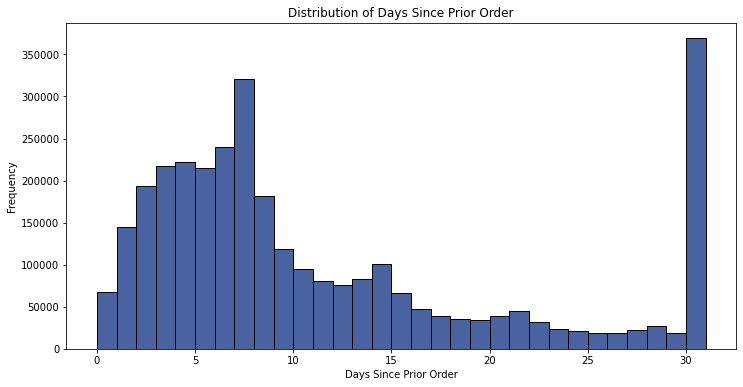

In [33]:
plt.figure(figsize=(12,6))
plt.hist(orders['days_since_prior_order'], bins=range(32), color ='#4863A0', edgecolor='black')



# Add labels and title
plt.xlabel('Days Since Prior Order')
plt.ylabel('Frequency')
plt.title('Distribution of Days Since Prior Order')

# Show the plot
plt.show()


we observe that the highest frequency of orders occurs when the days since the prior order are low, particularly within the first few days. Specifically, the frequency peaks when the days since the prior order range from 1 to 7, indicating that a significant portion of customers tends to reorder within a week's time. Conversely, the lowest frequency of orders is evident when the days since the prior order extend beyond two weeks, with a notable decline observed after the 14-day mark.and reurn increae to peak after 30 days.

In [34]:
days_since_prior_order_counts = orders['days_since_prior_order'].value_counts().reset_index()
days_since_prior_order_counts.columns = ['Days Since Prior Order', 'Frequency']

# Sort the DataFrame by 'Days Since Prior Order'
days_since_prior_order_counts = days_since_prior_order_counts.sort_values(by='Days Since Prior Order').astype(int)

# Display the DataFrame
days_since_prior_order_counts



Days Since Prior Order  Frequency
15                       0      67755
8                        1     145247
6                        2     193206
4                        3     217005
3                        4     221696
5                        5     214503
2                        6     240013
1                        7     320608
7                        8     181717
9                        9     118188
11                      10      95186
13                      11      80970
14                      12      76146
12                      13      83214
10                      14     100230
16                      15      66579
17                      16      46941
19                      17      39245
21                      18      35881
22                      19      34384
20                      20      38527
18                      21      45470
23                      22      32012
25                      23      23885
27                      24      20712
28                      25      19234
30                      26      19016
26                      27      22013
24                      28      26777
29                      29      19191
0                       30     369323

we observe that the highest frequency of orders occurs when the days since the prior order are low, particularly within the first few days. Specifically, the frequency peaks when the days since the prior order range from 1 to 7, indicating that a significant portion of customers tends to reorder within a week's time. Conversely, the lowest frequency of orders is evident when the days since the prior order extend beyond two weeks, with a notable decline observed after the 14-day mark.and reurn increae to peak after 30 days.

## monitoring the effect of reordered ratio on product position in the cart

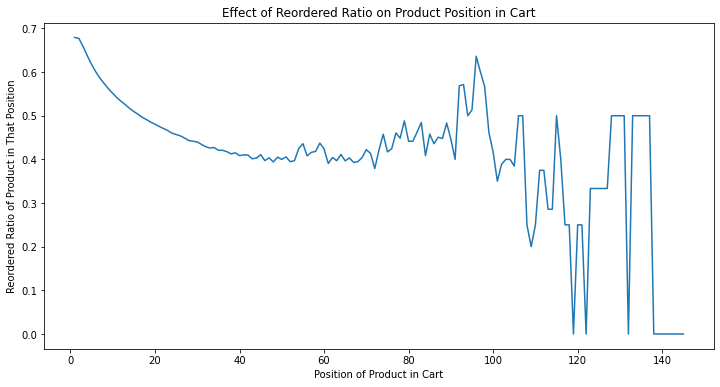

In [35]:
# Calculating the mean reorder ratio of products based on their add to cart position
grouped = order_products.groupby(['add_to_cart_order']).agg({'reordered':'mean'}).reset_index()
plt.figure(figsize=(12,6))
# Visualizing the relationship between add to cart position and reorder ratio
sns.lineplot(x=grouped['add_to_cart_order'], y=grouped['reordered'])
plt.title('Effect of Reordered Ratio on Product Position in Cart')
plt.xlabel('Position of Product in Cart')
plt.ylabel('Reordered Ratio of Product in That Position')
plt.show()

It appears that products added to the cart initially have a higher probability of being reordered compared to those added later. This observation aligns with the common behavior of first adding frequently purchased items to the cart and then exploring new products. This trend suggests that customers prioritize replenishing familiar items before considering new ones during their shopping sessions.

In [36]:
grouped

add_to_cart_order  reordered
0                    1   0.679302
1                    2   0.677135
2                    3   0.658426
3                    4   0.637350
4                    5   0.617598
..                 ...        ...
140                141   0.000000
141                142   0.000000
142                143   0.000000
143                144   0.000000
144                145   0.000000

[145 rows x 2 columns]

In [37]:
del grouped

##	analyzing the distribution of products across departments.  Analyzing departments

In [38]:

# Group by 'department_id' and count the number of unique products for each department
products_per_department = products.groupby('department_id')['product_id'].nunique().reset_index(name='product_count')

# Merge with 'departments' DataFrame to get department names
products_per_department = products_per_department.merge(departments, on='department_id', how='left')

# Sort the DataFrame by product_count in descending order
products_per_department = products_per_department.sort_values(by='product_count', ascending=False)

# Create a pie chart
fig_pie = px.pie(products_per_department, values='product_count', names='department',
                 title='Distribution of Products Across Departments (Pie Chart)')
fig_pie.show()

# Create a treemap
fig_treemap = px.treemap(products_per_department, path=['department'], values='product_count',
                          title='Distribution of Products Across Departments (Treemap)')
fig_treemap.show()


## Analyzing the distribution of purchases across departments provides valuable insights into customer behavior.

In [39]:
department_purchases = order_products.groupby('department_id')['order_id'].count().reset_index(name='purchase_count')

# Merge with 'departments' DataFrame to get department names
department_purchases = department_purchases.merge(departments, on='department_id', how='left')

# Sort the DataFrame by purchase_count in descending order
department_purchases = department_purchases.sort_values(by='purchase_count', ascending=False)

# Create a pie chart
fig_pie = px.pie(department_purchases, values='purchase_count', names='department',
                 title='Distribution of Purchases Across Departments')
fig_pie.show()

# Create a treemap
fig_treemap = px.treemap(department_purchases, path=['department'], values='purchase_count',
                         title='Distribution of Purchases Across Departments (Treemap)')
fig_treemap.show()

It appears that while the "Produce" department comprises only a small fraction of the total number of products available (2%), it accounts for a significant portion (29%) of the total purchases made.

Produce is the largest department. Now let us check the reordered percentage of each department.

In [40]:
del department_purchases, products_per_department

### 	Department wise reorder ratio:

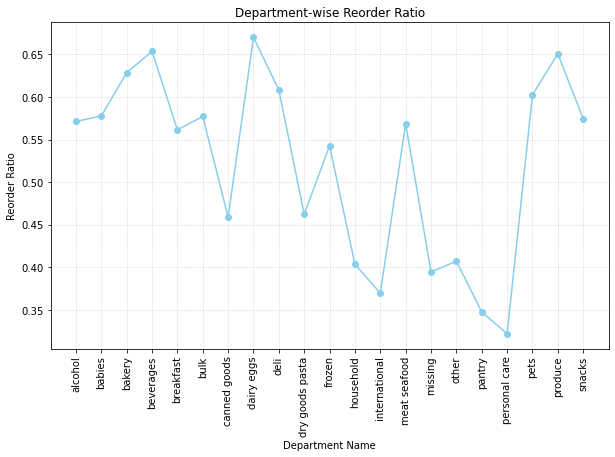

In [41]:
# Calculate the reorder ratio for each department
department_reorder_ratio = order_products.groupby('department')['reordered'].mean().reset_index()

# Sorting the DataFrame by department_id
department_reorder_ratio = department_reorder_ratio.sort_values(by='department')

# Create a line chart
plt.figure(figsize=(10, 6))
plt.plot(department_reorder_ratio['department'], department_reorder_ratio['reordered'], marker='o', color='skyblue', linestyle='-')

# Add labels and title
plt.xlabel('Department Name')
plt.ylabel('Reorder Ratio')
plt.title('Department-wise Reorder Ratio')
# Set the x-axis ticks to match department IDs
plt.xticks(department_reorder_ratio['department'])
plt.xticks(rotation=90)
plt.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
plt.show()

Customers who purchase items from the Dairy & Eggs and Produce departments are likely to exhibit higher reordering tendencies compared to those who buy from the Personal Care category.

In [42]:
del department_reorder_ratio

## Now let us look at the important aisles. Analyzing sub-departments

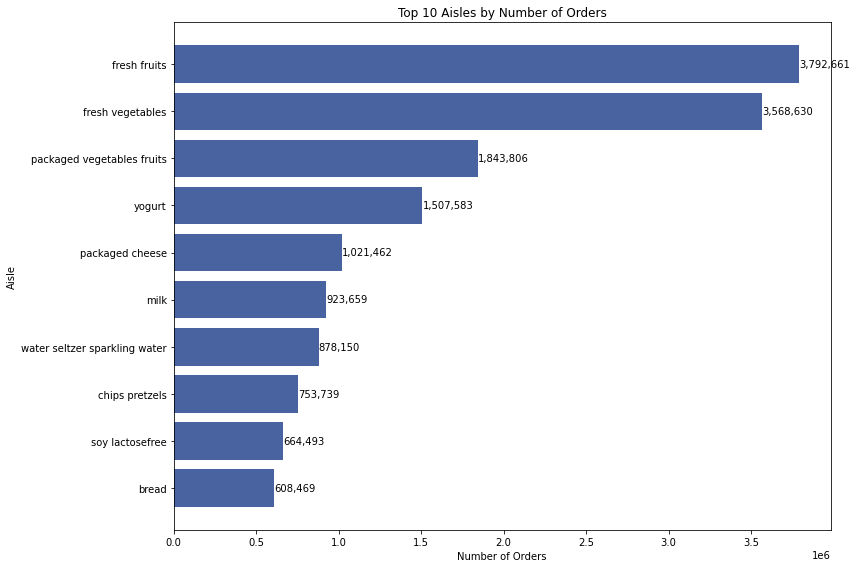

In [43]:
# Group by 'aisle_id' and count the number of orders for each aisle
aisle_orders = order_products.groupby('aisle_id')['order_id'].count().reset_index(name='order_count')

# Merge with 'aisles' DataFrame to get aisle names
aisle_orders = aisle_orders.merge(aisles, on='aisle_id', how='left')

# Sort the DataFrame by order_count in descending order
top_10_aisles = aisle_orders.sort_values(by='order_count', ascending=False).head(10)

# Create a bar plot to visualize the top 10 aisles
plt.figure(figsize=(12, 8))
bars = plt.barh(top_10_aisles['aisle'], top_10_aisles['order_count'], color='#4863A0')

# Add data labels to the bars
for bar in bars:
    plt.text(bar.get_width(), bar.get_y() + bar.get_height()/2, 
             f'{int(bar.get_width()):,}', 
             va='center', ha='left', fontsize=10, color='black')

plt.xlabel('Number of Orders')
plt.ylabel('Aisle')
plt.title('Top 10 Aisles by Number of Orders')
plt.gca().invert_yaxis()  # Invert y-axis to display the aisle with the highest order count at the top
plt.tight_layout()
plt.show()

The top two aisles are fresh fruits and fresh vegetables.

In [44]:
del aisle_orders

## Calculating the ratio of the reordered for each Aisle

Aisle Performance: By calculating the ratio of the 'reordered' column for each aisle, that help to understand the average likelihood of products in each aisle being reordered.

In [45]:
# Group by 'aisle_id' and calculate the mean of the 'reordered' column for each aisle
aisle_reorder_ratio = order_products.groupby('aisle_id')['reordered'].mean().reset_index(name='reorder_ratio')

# Merge with 'aisles' DataFrame to get aisle names
aisle_reorder_ratio = aisle_reorder_ratio.merge(aisles, on='aisle_id', how='left')

# Sort the DataFrame by reorder_ratio in descending order
aisle_reorder_ratio = aisle_reorder_ratio.sort_values(by='reorder_ratio', ascending=False)

# Display the text-based visualization

print("Aisle\t\t\t\tReorder Ratio")
print("-------------------------------------------")
for index, row in aisle_reorder_ratio.iterrows():
    print(f"{row['aisle']: <40}\t{row['reorder_ratio']:.2f}")
    
aisle_reorder_ratio

Aisle				Reorder Ratio
-------------------------------------------
milk                                    	0.78
water seltzer sparkling water           	0.73
fresh fruits                            	0.72
eggs                                    	0.71
soy lactosefree                         	0.69
packaged produce                        	0.69
yogurt                                  	0.69
cream                                   	0.69
bread                                   	0.67
refrigerated                            	0.66
breakfast bakery                        	0.65
energy sports drinks                    	0.65
soft drinks                             	0.64
packaged vegetables fruits              	0.64
white wines                             	0.63
frozen breakfast                        	0.63
cat food care                           	0.62
trail mix snack mix                     	0.62
prepared meals                          	0.62
bulk dried fruits vegetables            	0.62
coffee       

aisle_id  reorder_ratio                          aisle
83         84       0.781812                           milk
114       115       0.729930  water seltzer sparkling water
23         24       0.718823                   fresh fruits
85         86       0.706359                           eggs
90         91       0.692361                soy lactosefree
..        ...            ...                            ...
131       132       0.212858                         beauty
117       118       0.195864                      first aid
9          10       0.194802               kitchen supplies
96         97       0.167595          baking supplies decor
103       104       0.152933              spices seasonings

[134 rows x 3 columns]

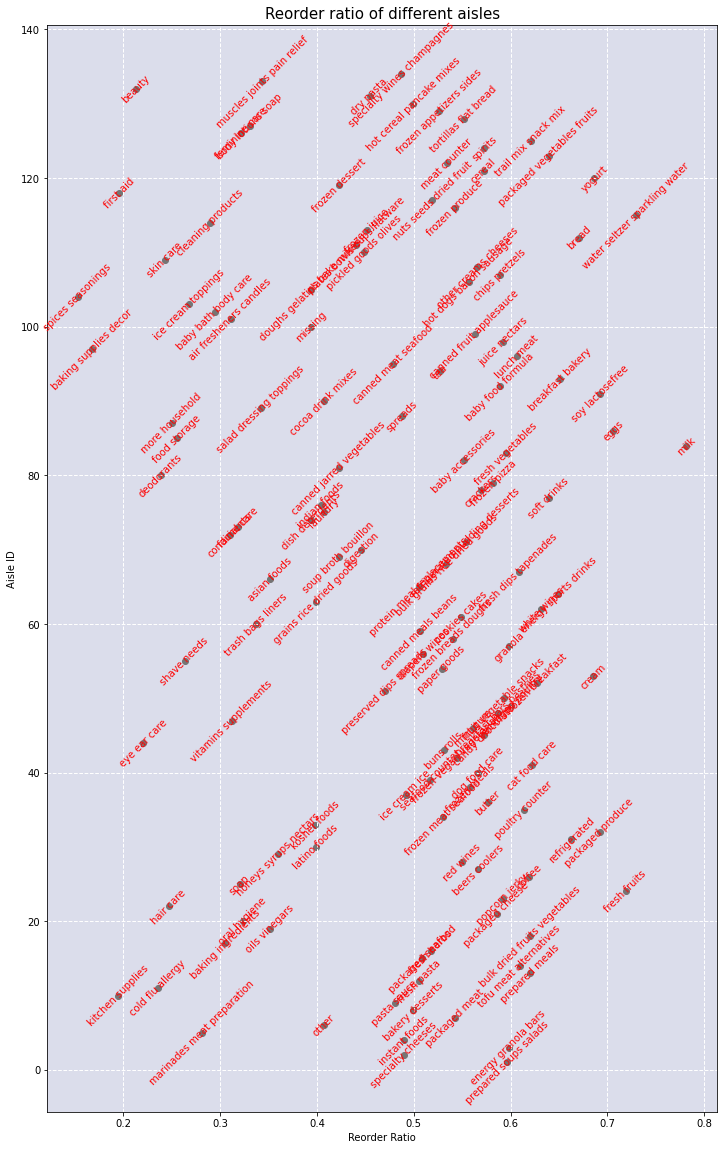

In [46]:
# Create the scatter plot
fig, ax = plt.subplots(figsize=(12,20))
ax.scatter(aisle_reorder_ratio.reorder_ratio.values, aisle_reorder_ratio.aisle_id.values, color='#757575')

# Annotate each point with the aisle name
for i, txt in enumerate(aisle_reorder_ratio.aisle.values):
    ax.annotate(txt, (aisle_reorder_ratio.reorder_ratio.values[i], aisle_reorder_ratio.aisle_id.values[i]),
                rotation=45, ha='center', va='center', color='red')

# Set labels and title
plt.xlabel('Reorder Ratio')
plt.ylabel('Aisle ID')
plt.title("Reorder ratio of different aisles", fontsize=15)

# Set background color of the plot
ax.set_facecolor('#DBDDEB')  # Change the background color here
ax.grid(True, linestyle='--', linewidth=1, color='White')
plt.show()

Aisles like "Milk," "Water Seltzer Sparkling Water," "Fresh Fruits," and "Eggs" have relatively high reorder ratios, the customers frequently repurchase items from these sections. These products are essentials or frequently consumed items in households.

In [47]:
del aisle_reorder_ratio

In [48]:
# Mutate 'organic' column based on product_name containing 'organic' (case-insensitive)
products['organic'] = products['product_name'].str.contains('organic', case=False)
products['organic'] = products['organic'].map({True: 'organic', False: 'not organic'})

# Convert 'organic' column to categorical type
organic_dtype = CategoricalDtype(categories=['organic', 'not organic'], ordered=True)
products['organic'] = products['organic'].astype(organic_dtype)
products

product_id                                       product_name  \
0               1                         Chocolate Sandwich Cookies   
1               2                                   All-Seasons Salt   
2               3               Robust Golden Unsweetened Oolong Tea   
3               4  Smart Ones Classic Favorites Mini Rigatoni Wit...   
4               5                          Green Chile Anytime Sauce   
...           ...                                                ...   
49683       49684          Vodka, Triple Distilled, Twist of Vanilla   
49684       49685                 En Croute Roast Hazelnut Cranberry   
49685       49686                                   Artisan Baguette   
49686       49687         Smartblend Healthy Metabolism Dry Cat Food   
49687       49688                             Fresh Foaming Cleanser   

       aisle_id  department_id      organic  
0            61             19  not organic  
1           104             13  not organic  
2            94              7  not organic  
3            38              1  not organic  
4             5             13  not organic  
...         ...            ...          ...  
49683       124              5  not organic  
49684        42              1  not organic  
49685       112              3  not organic  
49686        41              8  not organic  
49687        73             11  not organic  

[49688 rows x 5 columns]

##	Analyzing organic products

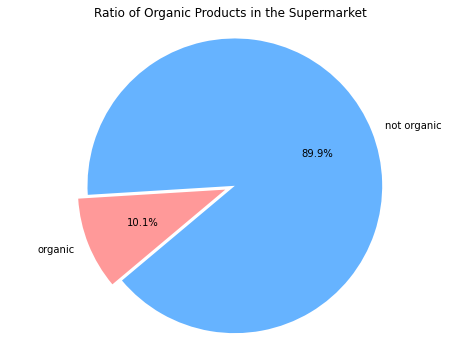

In [49]:
total_products_count = products.shape[0]

# Calculate the ratio of organic products
organic_ratio = products['organic'].value_counts() / total_products_count * 100
explode = (0.07, 0)

# Reverse the colors
colors = ['#66b3ff', '#ff9999']  # Reversed colors compared to the original

# Create a bar plot
plt.figure(figsize=(8, 6))
plt.pie(organic_ratio.values, explode=explode, labels=organic_ratio.index, autopct='%1.1f%%', colors=colors, startangle=220,)
plt.title('Ratio of Organic Products in the Supermarket')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle
plt.show()

Reordering Organic vs Non-Organic People more often reorder organic products vs non-organic products.

       organic  mean_reordered
0      organic        0.635387
1  not organic        0.569209


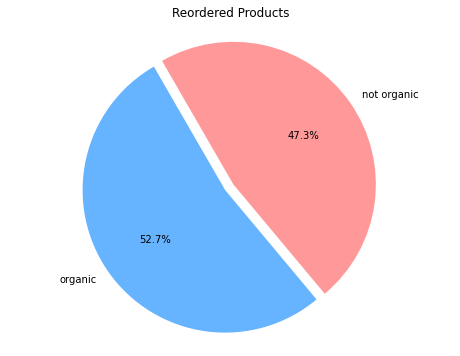

In [50]:
merged_df = pd.merge(order_products, products, on='product_id', how='left')

# Group by 'organic' column and calculate the mean of 'reordered' for each group
tmp = merged_df.groupby('organic')['reordered'].mean().reset_index()
tmp.columns = ['organic', 'mean_reordered']

# Print the summarized data
print(tmp)
explode = (0.07, 0)
# Create the bar plot using seaborn
plt.figure(figsize=(8, 6))
plt.pie(tmp['mean_reordered'],explode = explode, labels=tmp['organic'], autopct='%1.1f%%', startangle=120, colors=colors)
plt.title('Reordered Products')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()

Percentage of buying organic products: 31.51%
Percentage of buying non-organic products: 68.49%


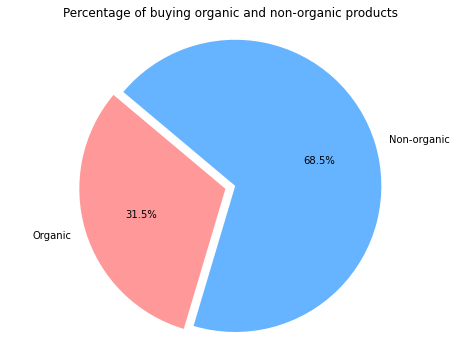

In [51]:
# Merge order_products and products DataFrames on 'product_id'
#merged_df = pd.merge(order_products, products, on='product_id', how='left')

# Count the frequency of buying organic and non-organic products
organic_frequency = merged_df['organic'].value_counts()

# Calculate the percentage of buying organic products
total_purchases = organic_frequency.sum()
percentage_organic = (organic_frequency['organic'] / total_purchases) * 100
percentage_non_organic = (organic_frequency['not organic'] / total_purchases) * 100

# Print the percentage
print("Percentage of buying organic products: {:.2f}%".format(percentage_organic))
print("Percentage of buying non-organic products: {:.2f}%".format(percentage_non_organic))


labels = ['Organic', 'Non-organic']
sizes = [percentage_organic, percentage_non_organic]
colors = ['#ff9999', '#66b3ff']
explode = (0.07, 0)  # explode the 1st slice (Organic)

plt.figure(figsize=(8, 6))
plt.pie(sizes, explode=explode, labels=labels, colors=colors, autopct='%1.1f%%', startangle=140)
plt.title('Percentage of buying organic and non-organic products')
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()



In [52]:
del merged_df

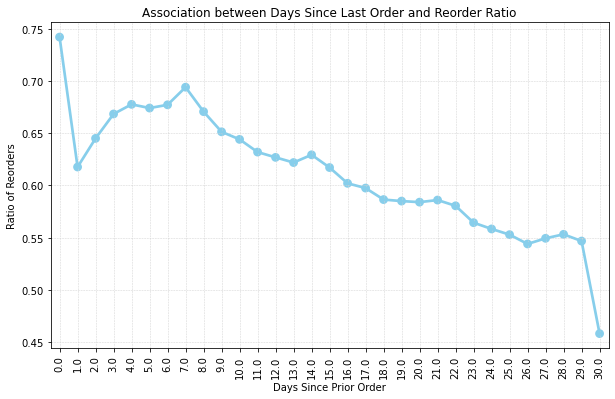

In [53]:
# Calculate the ratio of reorders for each day since the last order
orders_grouped = order_products.groupby('days_since_prior_order')['reordered'].mean().reset_index()

# Create a point plot
plt.figure(figsize=(10, 6))
sns.pointplot(data=orders_grouped, x='days_since_prior_order', y='reordered', color='skyblue')

# Add labels and title
plt.xlabel('Days Since Prior Order')
plt.ylabel('Ratio of Reorders')
plt.title('Association between Days Since Last Order and Reorder Ratio')
plt.grid(True, linestyle='--', color='lightgray', linewidth=0.5)
plt.xticks(rotation=90)
plt.show()

Association between days since last order and the ratio of reorders

74 % of products bought at the same day of prev order, are reorders

69% of products bought after 1 week of prev order, are reorders

Conculsion:

if future order will be at the same day of prev order, percentage of reorders in the future product is high.

if future order will be after a week from the prev order, percentage of reorders in the future product is high.

## Relationship between Add to Cart Order and Reorder Ratio

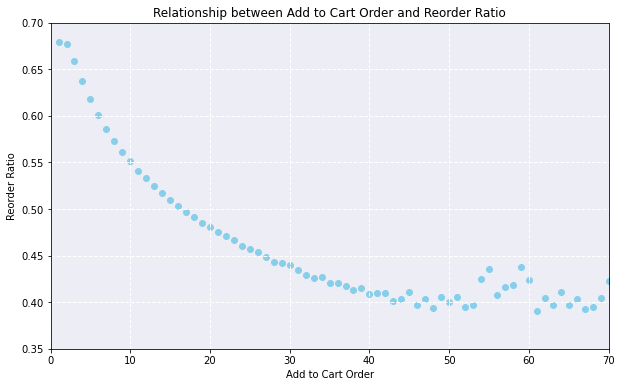

In [54]:
# Calculate the reorder ratio by add_to_cart_order
reorder_ratio_by_order = order_products.groupby('add_to_cart_order')['reordered'].mean().reset_index()

# Create the scatter plot
fig, ax = plt.subplots(figsize=(10, 6))
ax.scatter(data=reorder_ratio_by_order, x='add_to_cart_order', y='reordered', color='skyblue')
ax.set_title('Relationship between Add to Cart Order and Reorder Ratio')
ax.set_xlabel('Add to Cart Order')
ax.set_ylabel('Reorder Ratio')
ax.set_facecolor('#EDEEF5')  # Change the background color here
ax.grid(True, linestyle='--', linewidth=1, color='White')
plt.ylim([0.35, 0.7])
plt.xlim([0, 70])
plt.show()


In [55]:
del reorder_ratio_by_order

## ----------------------------------------------------------------------
